In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("../")

In [20]:
from sprintdl.main import *
# from sprintdl.nets import *

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

# Define required

In [4]:
fpath = Path("/media/hdd/Datasets/ArtClass/")

tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 256

# Actual process

In [5]:
il = ImageList.from_files(fpath, tfms=tfms)

In [6]:
il

ImageList (36702 items)
[PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/72464485_484151519164558_7996390942427275987_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67061598_659075951237852_8193482831220395614_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/52369429_387255328723206_9033916457772710578_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67249582_2358754971005882_1419227919627445111_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/53117277_787218161655836_7400982805295717482_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/66306740_2081645612139014_2862011611265245646_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/51053509_419271458822091_6368645951995838212_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mim

In [7]:
tm= Path("/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg")

In [8]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-3], proc_y=CategoryProcessor())

In [9]:
n_classes = len(set(ll.train.y.items))

In [10]:
data = ll.to_databunch(bs, c_in=3, c_out=2)

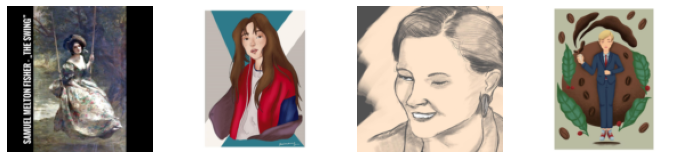

In [11]:
show_batch(data, 4)

In [58]:
def lin_comb(v1, v2, beta): 
    print(beta.shape, v1.shape, v2.shape)
    return beta.T*v1 + (1-beta)*v2

In [59]:
class MixUp(Callback):
    _order = 90 
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return 
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))


In [60]:
lr = .001
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
    partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
    MixUp,
#     LR_Find,
    partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
# arch = partial(xresnet34, n_classes)
arch = get_vision_model("resnet34", n_classes=n_classes, pretrained=True)

# opt_func = partial(sgd_mom_opt, wd=0.01)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
# opt_func = lamb

# Training

In [61]:
clear_memory()

In [62]:
learn = Learner(arch,  data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [63]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


torch.Size([256, 1]) torch.Size([256, 3, 128, 128]) torch.Size([256, 3, 128, 128])


RuntimeError: The size of tensor a (256) must match the size of tensor b (128) at non-singleton dimension 3

In [66]:
save_model(learn, "m1", fpath)

Saved at /media/hdd/Datasets/ArtClass/models/m1


PosixPath('/media/hdd/Datasets/ArtClass/models/m1')

In [67]:
temp = Path('/media/hdd/Datasets/ArtClass/Popular/artgerm/10004370_1657536534486515_1883801324_n.jpg')

get_class_pred(temp, learn ,ll, 128)

'Popular'

In [68]:
temp = Path('/home/eragon/Downloads/Telegram Desktop/IMG_1800.PNG')

In [69]:
get_class_pred(temp, learn ,ll,128)

'Unpopular'

In [70]:
temp = Path('/home/eragon/Downloads/Telegram Desktop/IMG_20210106_180731.jpg')

In [71]:
get_class_pred(temp, learn ,ll,128)

'Popular'

# Digging in

In [39]:
# classification_report(learn, n_classes, device)

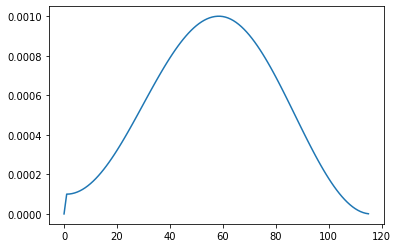

In [35]:
learn.recorder.plot_lr()

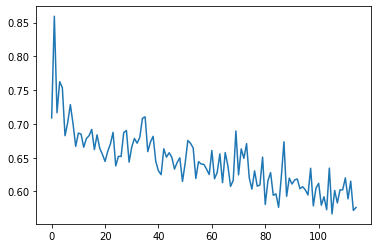

In [36]:
learn.recorder.plot_loss()

# Model vis

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.535883,0.762688,0.558465,0.741499,01:59


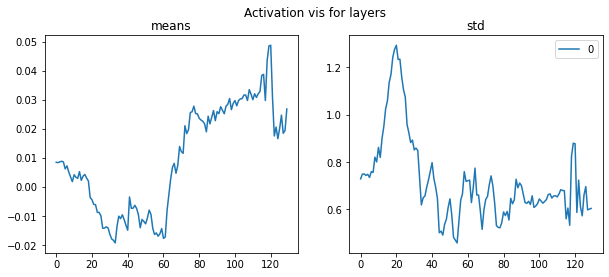

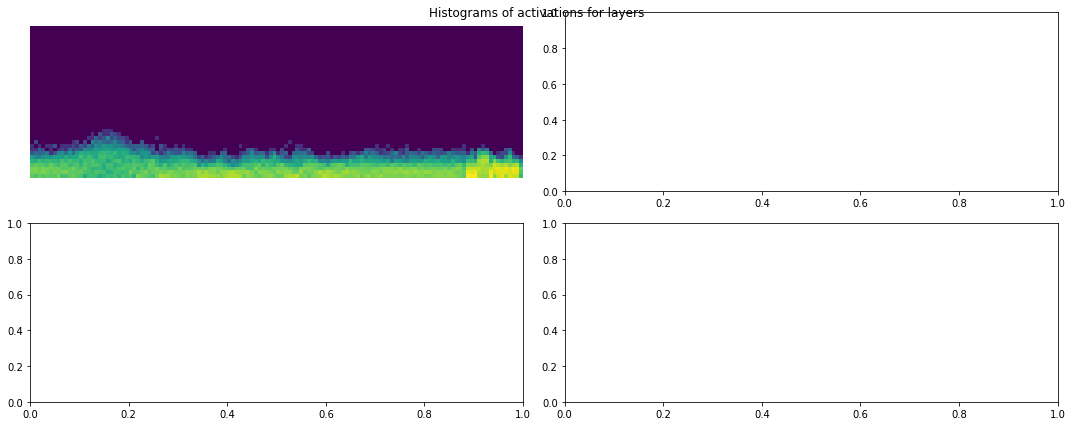

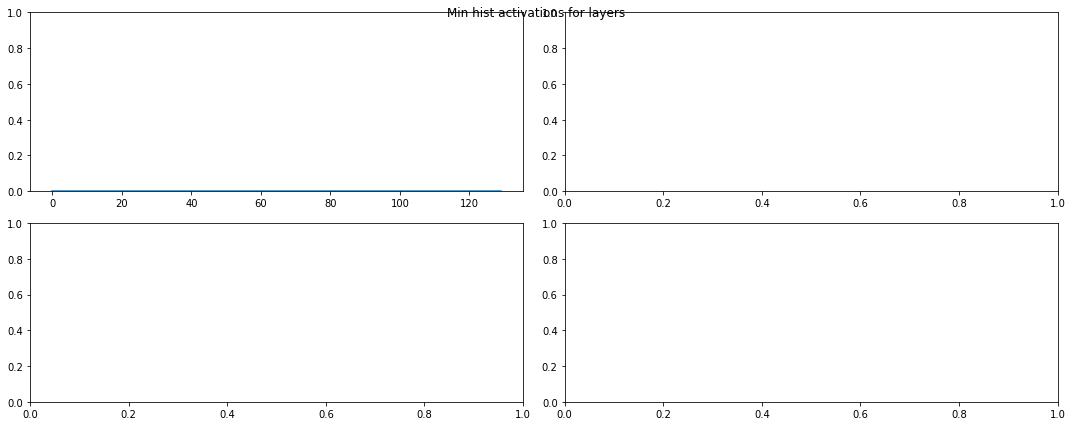

In [81]:
run_with_act_vis(1, learn)

# Multiple runs with model saving

In [122]:
dict_runner = {
    "xres18":[1, partial(xresnet18, c_out=n_classes)(), data, loss_func, .001, cbfs,opt_func],
    "xres34":[1, partial(xresnet34, c_out=n_classes)(), data, loss_func, .001, cbfs,opt_func],
    "xres50":[1, partial(xresnet50, c_out=n_classes)(), data, loss_func, .001, cbfs,opt_func],
}

In [123]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [129]:
multiple_runner(dict_runner, fpath)

Training model: xres18


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.631594,0.666667,0.598225,0.695818,01:47


Training model: xres34


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.635402,0.662340,0.597110,0.700699,01:55


Training model: xres50


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 7.80 GiB total capacity; 6.52 GiB already allocated; 72.31 MiB free; 6.68 GiB reserved in total by PyTorch)